# Clustering

Problems:




In [297]:
# Useful starting lines
%matplotlib inline
import copy
#import matplotlib as mpl
import datetime as dt
import matplotlib.pyplot as plt
import re
import glob
import ast
from datetime import datetime
from collections import Counter
import itertools
import nltk
nltk.download("stopwords")
from nltk import bigrams 
from nltk.corpus import stopwords
import string
import locale
import reverse_geocoder as rg
import multiprocessing as mp
import dask.dataframe as dd
import pickle
locale.setlocale(locale.LC_TIME, "en_US.utf8")
%load_ext autoreload

[nltk_data] Downloading package stopwords to /home/servan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
import pandas as pd
from sklearn.utils import shuffle
import numpy as np 
from sklearn import preprocessing

## Start from here if "states_4m.pkl" and "vec_sent_4m.pkl already exist

In [14]:
y_start = pd.read_pickle("states_4m.pkl")
x_start = pd.read_pickle("vec_sent_small.pkl")

In [15]:
Y = y_start.loc[0:200000]
X = x_start.loc[0:200000,0:699]
X,Y = shuffle(X,Y,random_state=2)

In [16]:
states_dict = {
#        'AK': 'Alaska',
        'AL': 'Alabama',
        'AR': 'Arkansas',
        #'AS': 'American Samoa',
        'AZ': 'Arizona',
        'CA': 'California',
        'CO': 'Colorado',
        'CT': 'Connecticut',
        'DC': 'District of Columbia',
        'DC1':'Washington, D.C.',
        'DE': 'Delaware',
        'FL': 'Florida',
        'GA': 'Georgia',
#        'GU': 'Guam',
#        'HI': 'Hawaii',
        'IA': 'Iowa',
        'ID': 'Idaho',
        'IL': 'Illinois',
        'IN': 'Indiana',
        'KS': 'Kansas',
        'KY': 'Kentucky',
        'LA': 'Louisiana',
        'MA': 'Massachusetts',
        'MD': 'Maryland',
        'ME': 'Maine',
        'MI': 'Michigan',
        'MN': 'Minnesota',
        'MO': 'Missouri',
        #'MP': 'Northern Mariana Islands',
        'MS': 'Mississippi',
        'MT': 'Montana',
        #'NA': 'National',
        'NC': 'North Carolina',
        'ND': 'North Dakota',
        'NE': 'Nebraska',
        'NH': 'New Hampshire',
        'NJ': 'New Jersey',
        'NM': 'New Mexico',
        'NV': 'Nevada',
        'NY': 'New York',
        'OH': 'Ohio',
        'OK': 'Oklahoma',
        'OR': 'Oregon',
        'PA': 'Pennsylvania',
        'PR': 'Puerto Rico',
        'RI': 'Rhode Island',
        'SC': 'South Carolina',
        'SD': 'South Dakota',
        'TN': 'Tennessee',
        'TX': 'Texas',
        'UT': 'Utah',
        'VA': 'Virginia',
        #'VI': 'Virgin Islands',
        'VT': 'Vermont',
        'WA': 'Washington',
        'WI': 'Wisconsin',
        'WV': 'West Virginia',
        'WY': 'Wyoming'
}

#linguistic regions: https://www.washingtonpost.com/blogs/govbeat/wp/2013/12/02/what-dialect-to-do-you-speak-a-map-of-american-english/?utm_term=.1156615c2e39
lingo_regions = {"West": ("Washington","Oregon","California","Idaho",
                "Montana","Nevada","Arizona","Utah","Wyoming","North Dakota",
                "South Dakota","Nebraska","Kansas","Oklahoma","Colorado",
                "New Mexico","Texas","Missouri","Iowa"),
                "UpperNorth": ("Minnesota","Wisconsin","Michigan","New York",
                "Massachusetts","Vermont","New Hampshire","Maine","Rhode Island",
                "Connecticut"),
                "LowerNorth": ("Pennsylvania","New Jersey","Ohio","Indiana","Illinois"),
                "UpperSouth": ("Delaware","Maryland","Washington, D.C.","West Virginia",
                "Kentucky","Tennessee"),
                "LowerSouth": ("Virginia","North Carolina","South Carolina","Georgia",
                "Florida","Alabama","Mississippi","Louisiana","Arkansas")}


In [17]:
#get state adjacency
with open("stateadjacency.txt") as f:
    states_ad = f.read().splitlines() 
states_ad = [i.split(",") for i in states_ad]

for k in range(0,len(states_ad)):
    states_ad[k] = [states_dict.get(item) for item in states_ad[k]]

#revome states that are not in our subset
states_ad = [i for i in states_ad if i!=[None]]
states_ad

[['Alabama', 'Mississippi', 'Tennessee', 'Georgia', 'Florida'],
 ['Arkansas',
  'Missouri',
  'Tennessee',
  'Mississippi',
  'Louisiana',
  'Texas',
  'Oklahoma'],
 ['Arizona', 'California', 'Nevada', 'Utah', 'Colorado', 'New Mexico'],
 ['California', 'Oregon', 'Nevada', 'Arizona'],
 ['Colorado',
  'Wyoming',
  'Nebraska',
  'Kansas',
  'Oklahoma',
  'New Mexico',
  'Arizona',
  'Utah'],
 ['Connecticut', 'New York', 'Massachusetts', 'Rhode Island'],
 ['District of Columbia', 'Maryland', 'Virginia'],
 ['Delaware', 'Maryland', 'Pennsylvania', 'New Jersey'],
 ['Florida', 'Alabama', 'Georgia'],
 ['Georgia',
  'Florida',
  'Alabama',
  'Tennessee',
  'North Carolina',
  'South Carolina'],
 ['Iowa',
  'Minnesota',
  'Wisconsin',
  'Illinois',
  'Missouri',
  'Nebraska',
  'South Dakota'],
 ['Idaho', 'Montana', 'Wyoming', 'Utah', 'Nevada', 'Oregon', 'Washington'],
 ['Illinois', 'Indiana', 'Kentucky', 'Missouri', 'Iowa', 'Wisconsin'],
 ['Indiana', 'Michigan', 'Ohio', 'Kentucky', 'Illinois'],


In [18]:
to_keep = Y.isin(states_dict.values())
print("Removed a total of "+ str(sum(~to_keep)) + " rows")
Y = Y[to_keep]
Y.index = range(0,np.shape(Y)[0])

Removed a total of 9391 rows


In [19]:
Y[Y=="Washington, D.C."] = "District of Columbia"
states = np.unique(Y)
#states[states=="Washington, D.C."] = "District of Columbia"

In [21]:
X = X[to_keep]
X.index = range(0,np.shape(X)[0])

In [23]:
#transform state strings into integer labels
le = preprocessing.LabelEncoder()
le.fit(Y)
list(le.classes_)
Y = pd.Series(le.transform(Y))

In [24]:
states_ad = [list(le.transform(i)) for i in states_ad]

In [25]:
states_ad = sorted(states_ad)

In [26]:
#split data into smaller subsets
splits = list(range(1,10))
splits = [i/10 for i in splits]
Y_splits = np.split(Y, [int(i*len(Y)) for i in splits])
X_splits = np.split(X,[int(i*len(Y)) for i in splits])

In [310]:
def neighbour_finder(X_splits,Y_splits,size=49):
    row = col = size
    neigh_mat_state = np.zeros([row,col])
    neigh_mat_neigh = np.zeros([row,col])
    for i in range(0,len(Y_splits)):
        Y = Y_splits[i]
        print(len(np.unique(Y)))
        X = X_splits[i]
        
        #calculate adjacency matrix
        rows = cols = len(Y)
        ad_mat = sps.coo_matrix((rows, cols))
        indices = list(pd.DataFrame(states_ad)[0])
        """
        if __name__ == '__main__':
            results = Parallel(n_jobs=mp.cpu_count()-2)(delayed(comp_ad_mat)(j,ad_mat) for j in indices)
         
        print("done1")
        ad_mat = sps.coo_matrix((rows, cols))
        for i in range(0,len(results)):
            print(i)
            ad_mat = ad_mat + results[i]
        print("done2")
        """
        ad_mat = ad_matrix(Y,states_ad)
        #reduce dimensions via pca
        pca = PCA(n_components=50, 
                         copy=True, whiten=False, svd_solver="auto", tol=0.0, 
                         iterated_power="auto", random_state=None)
        X_pca = pca.fit_transform(X)
        
        #create cluster model
        agg_cluster = AgglomerativeClustering(n_clusters=5, affinity="cosine", memory=None, connectivity=ad_mat, 
                                        compute_full_tree="auto", linkage="average")
        labels = pd.Series(agg_cluster.fit_predict(X_pca))
        Y.reset_index(drop=True, inplace=True)
        labels.reset_index(drop=True, inplace=True)

        Y1 = pd.concat([Y,labels],axis=1,ignore_index=True)
        print(pd.unique(Y1[1]))
        #calculate majority label for each state, based on values within state only
        #"categs_state" and values in state_neighbourhood conly "categs_neigh"
        categs_state = categ_calculator(Y1,states_ad,neigh=False)
        categs_neigh = categ_calculator(Y1,states_ad,neigh=True)
        
        #calculate neighbour
        neigh_mat_neigh = neigh_calc(categs_neigh,neigh_mat_neigh)
        neigh_mat_state = neigh_calc(categs_state,neigh_mat_state)
        np.save("neigh_mat_state_200k.npy",neigh_mat_state)
        np.save("neigh_mat_neigh_200k.npy",neigh_mat_neigh)
        print(str(i),"th split processed\n")
    return([neigh_mat_neigh,neigh_mat_state])

In [311]:
nei_mat = neighbour_finder(X_splits,Y_splits)

49
[1 0 4 2 3]
[12281, 4054, 146, 1, 2579]
49
[12281, 4054, 146, 1, 2579]
case2
case2
case1
49
0 th split processed

49
[0 1 2 3 4]
[16295, 2679, 80, 6, 1]
49
[16295, 2679, 80, 6, 1]
case2
case1
case2
case2
case1
case2
case2
case2
case2
49
1 th split processed

49
[0 3 1 2 4]
[2769, 11865, 25, 4388, 14]
49
[2769, 11865, 25, 4388, 14]
case2
49
2 th split processed

49
[1 3 0 4 2]
[472, 16003, 2, 2582, 2]
49
[472, 16003, 2, 2582, 2]
case2
case2
case2
case2
case1
49
3 th split processed

49
[0 3 2 1 4]
[2573, 3255, 9730, 2972, 531]
49
[2573, 3255, 9730, 2972, 531]
49
4 th split processed

49
[1 3 4 2 0]
[15, 11197, 2463, 3837, 1549]
49
[15, 11197, 2463, 3837, 1549]
49
5 th split processed

49
[0 1 2 3 4]
[14378, 2622, 1619, 376, 66]
49
[14378, 2622, 1619, 376, 66]
49
6 th split processed

49
[4 0 1 3 2]
[3486, 2531, 1981, 174, 10889]
49
[3486, 2531, 1981, 174, 10889]
49
7 th split processed

49
[0 1 3 4 2]
[15206, 2519, 2, 1235, 99]
49
[15206, 2519, 2, 1235, 99]
case2
case1
case2
case2
49

In [340]:
def find_neigh(ngh_mat):
    nghs = []
    for i in range(0,len(ngh_mat)):
        ngh = [j>=6 for j in ngh_mat[i]]
        nghs.append(list(ngh_mat).index(True))
    return(nghs)
        

In [341]:
find_neigh(nei_mat[0])

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [ ]:
row = col = len(np.unique(Y_splits[0]))
row

In [170]:
def neigh_calc(categs,neigh_mat):
    for j in range(0,row):
        cat_j = categs[j]
        neighs = [(i==cat_j)*1 for i in categs]
        neigh_mat[j,:] = neigh_mat[j,:]+neighs
    return(neigh_mat)

In [164]:
[(i==3)*1 for i in categs]

[1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0]

In [192]:
#merged = list(itertools.chain.from_iterable(list2d))
def ad_matrix(Y,states_ad):
    rows = cols = len(Y)
    ad_mat = sps.coo_matrix((rows, cols))
    indices = list(pd.DataFrame(states_ad)[0])
    for j in indices: 
        r = np.where(Y.isin([j]))[0]
        tw_per_state = len(r)
        c = np.where(Y.isin(states_ad[j]))[0]
        #c = np.where(Y.isin([j]))[0]
        neigh_per_tweet = len(c)
        r = np.repeat([r],neigh_per_tweet,axis=1)
        r = list(itertools.chain.from_iterable(r))
        #print(r)
        c = np.repeat([c],tw_per_state,axis=0)
        c = list(itertools.chain.from_iterable(c))
        #print(c)
        d = np.ones(len(c))
        ad_mat = ad_mat + sps.coo_matrix((d, (r, c)), shape=(rows, cols))
    #print(ad_mat)
    return(ad_mat)

In [153]:
ad_matrix(Y,states_ad)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48]


<9446x9446 sparse matrix of type '<class 'numpy.float64'>'
	with 14318992 stored elements in Compressed Sparse Row format>

In [64]:
import scipy.sparse as sps
import itertools
from joblib import Parallel, delayed

rows = cols = len(Y)
ad_mat = sps.coo_matrix((rows, cols))
indices = list(pd.DataFrame(states_ad)[0])
print(indices)

def comp_ad_mat(j,ad_mat):
    #Y = avg_Y
    r = np.where(Y.isin([j]))[0]
    tw_per_state = len(r)
    c = np.where(Y.isin(states_ad[j]))[0]
    #c = np.where(Y.isin([j]))[0]
    neigh_per_tweet = len(c)
    r = np.repeat([r],neigh_per_tweet,axis=1)
    r = list(itertools.chain.from_iterable(r))
    #print(r)
    c = np.repeat([c],tw_per_state,axis=0)
    c = list(itertools.chain.from_iterable(c))
    #print(c)
    d = np.ones(len(c))
    ad_mat = ad_mat + sps.coo_matrix((d, (r, c)), shape=(rows, cols))
    return(ad_mat)
        
if __name__ == '__main__':
    results = Parallel(n_jobs=mp.cpu_count()-2)(delayed(comp_ad_mat)(j,ad_mat) for j in indices)

ad_mat = sps.coo_matrix((rows, cols))
for i in range(0,len(results)):
    print(i)
    ad_mat = ad_mat + results[i]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48]
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48


In [375]:
#regions = Y
regions = pd.Series(np.zeros(len(Y)))
for i in range(len(lingo_regions.keys())):
    reg_ind = Y.isin(list(lingo_regions.values())[i])
    regions[reg_ind] = [list(lingo_regions.keys())[i]]*sum(reg_ind)
    #regions[reg_ind] = [i]*sum(reg_ind)

In [65]:
ad_mat

<9446x9446 sparse matrix of type '<class 'numpy.float64'>'
	with 14318992 stored elements in Compressed Sparse Row format>

In [48]:
ad_mat

<47340x47340 sparse matrix of type '<class 'numpy.float64'>'
	with 104613790 stored elements in Compressed Sparse Row format>

### read sent-vector

In [25]:
X = tfidf_bigrams[0:10001,:]

In [66]:
print(np.shape(Y))
print(np.shape(X))

(9446,)
(9446, 700)


In [352]:
#dimensionality reduction
from sklearn.decomposition import PCA
pca = PCA(n_components=10, 
                         copy=True, whiten=False, svd_solver="auto", tol=0.0, 
                         iterated_power="auto", random_state=None)
X_pca = pca.fit_transform(X)

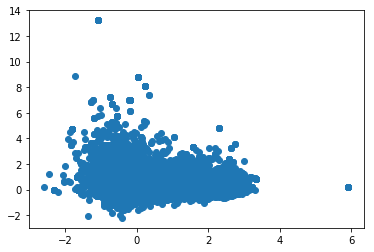

In [361]:
plt.scatter(X_pca[:,1],X_pca[:,3])

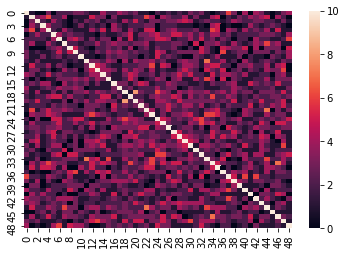

In [348]:
import seaborn as sns
sns.heatmap(np.array(nei_mat[1]))

In [81]:
from sklearn.cluster import AgglomerativeClustering
agg_cluster = AgglomerativeClustering(n_clusters=5, affinity="euclidean", memory=".", connectivity=ad_mat, 
                                        compute_full_tree="auto", linkage="ward")

In [82]:
labels = pd.Series(agg_cluster.fit_predict(X_pca))

In [83]:
labels

0       0
1       0
2       2
3       0
4       2
5       2
6       4
7       2
8       2
9       2
10      3
11      3
12      0
13      0
14      3
15      3
16      2
17      2
18      2
19      2
20      1
21      2
22      2
23      0
24      2
25      0
26      1
27      2
28      2
29      2
       ..
9416    2
9417    0
9418    0
9419    2
9420    2
9421    0
9422    0
9423    4
9424    2
9425    2
9426    0
9427    2
9428    0
9429    2
9430    3
9431    2
9432    2
9433    2
9434    2
9435    2
9436    2
9437    0
9438    2
9439    2
9440    2
9441    2
9442    2
9443    2
9444    2
9445    0
Length: 9446, dtype: int64

In [92]:
Y1 = pd.concat([Y,labels],1)

In [ ]:
Y1.to_pickle("Y1.pkl")

In [ ]:
n_clusts = range(2,15)
models = []
labels = []
Y1_vecs = []
for i in n_clusts:
    cluster_model = AgglomerativeClustering(n_clusters=i, affinity="cosine", memory=".", connectivity=ad_mat, 
                                        compute_full_tree="auto", linkage="average")
    #cluster_model = DBSCAN(eps=0.5, min_samples=5, metric="cosine", 
    #                       metric_params=None, algorithm="brute", leaf_size=30, p=None, n_jobs=8)
    models.append(cluster_model)
    cluster_model.fit(X)
    label = pd.Series(cluster_model.predict(X))
    labels.append(label)
    Y1 = pd.concat([Y,label],1)
    Y1_vecs.append(Y1)

In [289]:
import heapq
def categ_calculator(Y1,states_ad,neigh=False):
    categs = []
    indices = list(pd.DataFrame(states_ad)[0])
    nr_states = len(pd.unique(Y1[0]))
    cat_sum = [sum(Y1[1]==i) for i in range(0,len(pd.unique(Y1[1])))]
    print(cat_sum)
    state_sum = [sum(Y1[0]==i) for i in range(0,nr_states)]
    for i in indices:
        #state = i
        neighbours = states_ad[i]
        state = Y1[Y1[0]==i]
        categ_state = [sum(state[1]==j) for j in range(0,len(pd.unique(Y1[1])))]
        categ_state_rel = [categ_state[l]/cat_sum[l] for l in range(0,len(pd.unique(Y1[1])))]
        categ_sums = np.zeros(len(pd.unique(Y1[1])))
        for k in neighbours:
            state = Y1[Y1[0]==k]
            categ_sums = categ_sums + [sum(state[1]==j) for j in range(0,len(pd.unique(Y1[1])))]
        categ_rel = [categ_sums[l]/cat_sum[l] for l in range(0,len(pd.unique(Y1[1])))]
       
        arg_state = np.argmax(categ_state_rel)
        arg_neigh = np.argmax(categ_rel)
        if False: #arg_neigh!=arg_state:
            print(i)
            print(categ_rel)
            print(categ_state_rel)
            print(categ_state)
            print(neighbours)
        #print(categ_rel)
        #print(np.argmax(categ_rel))
        #if True:
        #    categs.append(np.argmax(categ_state_rel))
        if neigh:
            if np.max(categ_state_rel)==1:
                print("case1")
                categs.append(np.argmax(categ_state_rel))
            elif np.max(categ_rel)==1:
                sec_larg = heapq.nlargest(2, range(0,len(categ_rel)), key=categ_rel.__getitem__)
                categs.append(sec_larg[1])
                print("case2")
            else:
                categs.append(np.argmax(categ_rel))
        else:
            categs.append(np.argmax(categ_state_rel))
        #categs.append(np.argmax(categ_rel))
    print(len(categs))
    return(categs)
    #print(categ_rel)
    #print(np.argmax(categ_rel))
    #print(categ_rel)


In [288]:
np.argmax(None)

0

In [125]:
categs_state = categ_calculator(Y1,states_ad,neigh=False)
categs_neigh = categ_calculator(Y1,states_ad,neigh=True)

[2640, 410, 5243, 892, 261]
[2640, 410, 5243, 892, 261]


In [123]:
row = col = len(np.unique(Y))
neighbours_matrix = np.zeros([row,col])
for j in range(0,row):
    cat_j = categs[j]
    neighs = [(i==cat_j)*1 for i in categs]
    neighbours_matrix[j,:] = neighbours_matrix[j,:]+neighs

In [119]:
np.save("neigh_mat_state.npy",neighbours_matrix)

In [532]:
state = Y1[Y1[0]==24]        
categ_state = [sum(state[1]==j) for j in range(0,len(pd.unique(Y1[1])))]
categ_state_rel = [categ_state[l]/cat_sum[l] for l in range(0,len(pd.unique(Y1[1])))]
print(categ_state)
print(categ_state_rel)

[6, 0, 0, 0, 0]
[0.0020646937370956643, 0.0, 0.0, 0.0, 0.0]


In [531]:
indices = list(pd.DataFrame(states_ad)[0])
print(indices)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48]


In [538]:
ind = le.transform(["Colorado"])
print(ind)
#Y1[Y==ind[0]]


[4]


[45, 1, 1, 1, 1]
4
[0.15555555555555556, 1.0, 0.0, 0.0, 0.0]
[0.022222222222222223, 0.0, 0.0, 0.0, 0.0]
[1, 0, 0, 0, 0]
[4, 48, 25, 14, 34, 29, 1, 42]
case2
10
[0.1111111111111111, 1.0, 0.0, 1.0, 0.0]
[0.022222222222222223, 0.0, 0.0, 0.0, 0.0]
[1, 0, 0, 0, 0]
[10, 24, 48, 42, 26, 35, 45]
case2
13
[0.13333333333333333, 0.0, 1.0, 0.0, 0.0]
[0.022222222222222223, 0.0, 0.0, 0.0, 0.0]
[1, 0, 0, 0, 0]
[13, 21, 47, 11, 23, 25, 39]
case2
21
[0.066666666666666666, 0.0, 1.0, 0.0, 1.0]
[0.022222222222222223, 0.0, 0.0, 0.0, 0.0]
[1, 0, 0, 0, 0]
[21, 47, 13, 39, 32]
case2
24
[0.022222222222222223, 1.0, 1.0, 1.0, 1.0]
[0.0, 0.0, 0.0, 1.0, 0.0]
[0, 0, 0, 1, 0]
[24, 32, 39, 48, 10]
24
[0.022222222222222223, 1.0, 1.0, 1.0, 1.0]
[0.0, 0.0, 0.0, 1.0, 0.0]
[0, 0, 0, 1, 0]
[24, 32, 39, 48, 10]
case1
25
[0.1111111111111111, 1.0, 1.0, 0.0, 0.0]
[0.022222222222222223, 0.0, 0.0, 0.0, 0.0]
[1, 0, 0, 0, 0]
[25, 39, 13, 23, 14, 4, 48]
case2
32
[0.022222222222222223, 0.0, 1.0, 1.0, 1.0]
[0.0, 0.0, 0.0, 0.0, 1.0]
[

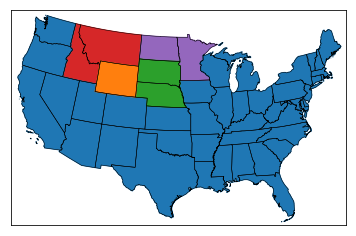

In [39]:
state_plotter(Y1)

## MiniBatch k-means

In [28]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import DBSCAN
n_clusts = range(2,15)
models = []
labels = []
Y1_vecs = []
for i in n_clusts:
    cluster_model = MiniBatchKMeans(n_clusters=i,max_iter=100,batch_size=1000,
                               verbose=0,compute_labels=True,
                               random_state=10)
    #cluster_model = DBSCAN(eps=0.5, min_samples=5, metric="cosine", 
    #                       metric_params=None, algorithm="brute", leaf_size=30, p=None, n_jobs=8)
    models.append(cluster_model)
    cluster_model.fit(X)
    label = pd.Series(cluster_model.predict(X))
    labels.append(label)
    Y1 = pd.concat([Y,label],1)
    Y1_vecs.append(Y1)
    


Init 1/3 with method: k-means++
Inertia for init 1/3: 55695.236810
Init 2/3 with method: k-means++
Inertia for init 2/3: 46359.049634
Init 3/3 with method: k-means++
Inertia for init 3/3: 53907.736210
Minibatch iteration 1/19100: mean batch inertia: 15.701521, ewa inertia: 15.701521 
Minibatch iteration 2/19100: mean batch inertia: 14.549291, ewa inertia: 15.689431 
Minibatch iteration 3/19100: mean batch inertia: 16.164718, ewa inertia: 15.694418 
Minibatch iteration 4/19100: mean batch inertia: 16.389849, ewa inertia: 15.701715 
Minibatch iteration 5/19100: mean batch inertia: 14.494023, ewa inertia: 15.689043 
Minibatch iteration 6/19100: mean batch inertia: 15.599584, ewa inertia: 15.688105 
Minibatch iteration 7/19100: mean batch inertia: 17.085069, ewa inertia: 15.702762 
Minibatch iteration 8/19100: mean batch inertia: 15.412603, ewa inertia: 15.699718 
Minibatch iteration 9/19100: mean batch inertia: 14.047521, ewa inertia: 15.682382 
Minibatch iteration 10/19100: mean batch in

Minibatch iteration 39/19100: mean batch inertia: 15.696843, ewa inertia: 15.246924 
Minibatch iteration 40/19100: mean batch inertia: 15.790824, ewa inertia: 15.252631 
Minibatch iteration 41/19100: mean batch inertia: 13.374365, ewa inertia: 15.232923 
Minibatch iteration 42/19100: mean batch inertia: 13.966622, ewa inertia: 15.219637 
Minibatch iteration 43/19100: mean batch inertia: 14.454226, ewa inertia: 15.211606 
Minibatch iteration 44/19100: mean batch inertia: 16.086606, ewa inertia: 15.220787 
Minibatch iteration 45/19100: mean batch inertia: 14.819050, ewa inertia: 15.216571 
Minibatch iteration 46/19100: mean batch inertia: 15.405844, ewa inertia: 15.218557 
Minibatch iteration 47/19100: mean batch inertia: 13.825327, ewa inertia: 15.203939 
Minibatch iteration 48/19100: mean batch inertia: 15.687490, ewa inertia: 15.209012 
Minibatch iteration 49/19100: mean batch inertia: 14.764962, ewa inertia: 15.204353 
Minibatch iteration 50/19100: mean batch inertia: 15.294465, ewa 

Minibatch iteration 30/19100: mean batch inertia: 13.996942, ewa inertia: 14.707310 
Minibatch iteration 31/19100: mean batch inertia: 13.965065, ewa inertia: 14.699522 
Minibatch iteration 32/19100: mean batch inertia: 13.133008, ewa inertia: 14.683085 
Minibatch iteration 33/19100: mean batch inertia: 13.480012, ewa inertia: 14.670462 
Minibatch iteration 34/19100: mean batch inertia: 14.600407, ewa inertia: 14.669727 
Minibatch iteration 35/19100: mean batch inertia: 13.241175, ewa inertia: 14.654738 
Minibatch iteration 36/19100: mean batch inertia: 12.192299, ewa inertia: 14.628900 
Minibatch iteration 37/19100: mean batch inertia: 12.878091, ewa inertia: 14.610530 
Minibatch iteration 38/19100: mean batch inertia: 14.929934, ewa inertia: 14.613881 
Minibatch iteration 39/19100: mean batch inertia: 14.213848, ewa inertia: 14.609684 
Minibatch iteration 40/19100: mean batch inertia: 15.088914, ewa inertia: 14.614712 
Minibatch iteration 41/19100: mean batch inertia: 12.462132, ewa 

Minibatch iteration 89/19100: mean batch inertia: 13.952001, ewa inertia: 14.379794 
Minibatch iteration 90/19100: mean batch inertia: 14.023933, ewa inertia: 14.376060 
Minibatch iteration 91/19100: mean batch inertia: 14.619987, ewa inertia: 14.378619 
Minibatch iteration 92/19100: mean batch inertia: 15.922723, ewa inertia: 14.394821 
Minibatch iteration 93/19100: mean batch inertia: 15.035169, ewa inertia: 14.401540 
Minibatch iteration 94/19100: mean batch inertia: 14.040256, ewa inertia: 14.397749 
Minibatch iteration 95/19100: mean batch inertia: 13.331002, ewa inertia: 14.386556 
Minibatch iteration 96/19100: mean batch inertia: 13.633231, ewa inertia: 14.378652 
Minibatch iteration 97/19100: mean batch inertia: 12.600251, ewa inertia: 14.359992 
Minibatch iteration 98/19100: mean batch inertia: 13.171006, ewa inertia: 14.347516 
Minibatch iteration 99/19100: mean batch inertia: 14.287437, ewa inertia: 14.346886 
Minibatch iteration 100/19100: mean batch inertia: 15.202875, ewa

Computing label assignment and total inertia
Init 1/3 with method: k-means++
Inertia for init 1/3: 43954.641423
Init 2/3 with method: k-means++
Inertia for init 2/3: 42174.347597
Init 3/3 with method: k-means++
Inertia for init 3/3: 43144.024541
Minibatch iteration 1/19100: mean batch inertia: 14.381481, ewa inertia: 14.381481 
Minibatch iteration 2/19100: mean batch inertia: 13.661473, ewa inertia: 14.373927 
Minibatch iteration 3/19100: mean batch inertia: 14.935964, ewa inertia: 14.379824 
Minibatch iteration 4/19100: mean batch inertia: 14.797088, ewa inertia: 14.384202 
Minibatch iteration 5/19100: mean batch inertia: 13.147220, ewa inertia: 14.371223 
Minibatch iteration 6/19100: mean batch inertia: 15.202827, ewa inertia: 14.379948 
Minibatch iteration 7/19100: mean batch inertia: 15.264747, ewa inertia: 14.389232 
Minibatch iteration 8/19100: mean batch inertia: 14.354134, ewa inertia: 14.388864 
Minibatch iteration 9/19100: mean batch inertia: 12.493696, ewa inertia: 14.368979

Minibatch iteration 78/19100: mean batch inertia: 14.516967, ewa inertia: 14.389875 
Minibatch iteration 79/19100: mean batch inertia: 13.674966, ewa inertia: 14.382374 
Minibatch iteration 80/19100: mean batch inertia: 14.181668, ewa inertia: 14.380268 
Minibatch iteration 81/19100: mean batch inertia: 13.624078, ewa inertia: 14.372334 
Minibatch iteration 82/19100: mean batch inertia: 12.156621, ewa inertia: 14.349085 
Minibatch iteration 83/19100: mean batch inertia: 12.728355, ewa inertia: 14.332079 
Minibatch iteration 84/19100: mean batch inertia: 13.994315, ewa inertia: 14.328535 
Minibatch iteration 85/19100: mean batch inertia: 13.656854, ewa inertia: 14.321488 
Minibatch iteration 86/19100: mean batch inertia: 15.396882, ewa inertia: 14.332771 
Minibatch iteration 87/19100: mean batch inertia: 13.748366, ewa inertia: 14.326639 
Minibatch iteration 88/19100: mean batch inertia: 12.769255, ewa inertia: 14.310298 
Minibatch iteration 89/19100: mean batch inertia: 13.873119, ewa 

Minibatch iteration 174/19100: mean batch inertia: 13.784708, ewa inertia: 14.103248 
Minibatch iteration 175/19100: mean batch inertia: 14.175590, ewa inertia: 14.104007 
Minibatch iteration 176/19100: mean batch inertia: 13.742981, ewa inertia: 14.100219 
Minibatch iteration 177/19100: mean batch inertia: 13.617348, ewa inertia: 14.095153 
Converged (lack of improvement in inertia) at iteration 177/19100
Computing label assignment and total inertia
Computing label assignment and total inertia
Init 1/3 with method: k-means++
Inertia for init 1/3: 43471.578465
Init 2/3 with method: k-means++
Inertia for init 2/3: 43026.162988
Init 3/3 with method: k-means++
Inertia for init 3/3: 42948.412046
Minibatch iteration 1/19100: mean batch inertia: 14.547311, ewa inertia: 14.547311 
Minibatch iteration 2/19100: mean batch inertia: 14.051303, ewa inertia: 14.542106 
Minibatch iteration 3/19100: mean batch inertia: 15.212302, ewa inertia: 14.549139 
Minibatch iteration 4/19100: mean batch inertia

Computing label assignment and total inertia


In [13]:
from sklearn.neighbors.ball_tree import BallTree
print(BallTree.valid_metrics)

['braycurtis', 'haversine', 'dice', 'l2', 'jaccard', 'canberra', 'hamming', 'euclidean', 'manhattan', 'sokalmichener', 'infinity', 'minkowski', 'kulsinski', 'mahalanobis', 'chebyshev', 'seuclidean', 'matching', 'l1', 'cityblock', 'russellrao', 'pyfunc', 'rogerstanimoto', 'sokalsneath', 'p', 'wminkowski']


In [78]:
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon

def state_plotter(Y1):
    nr_states = len(pd.unique(Y1[0]))
    """
    nr_states = len(pd.unique(Y1[0]))
    cat_sum = [sum(Y1[1]==i) for i in range(0,len(pd.unique(Y1[1])))]
    state_sum = [sum(Y1[0]==i) for i in range(0,nr_states)]

    categs = []
    for i in range(0,nr_states):
        state = Y1[Y1[0]==i]
        categ_sums = [sum(state[1]==j) for j in range(0,len(pd.unique(Y1[1])))]
        categ_rel = [categ_sums[k]/cat_sum[k] for k in range(0,len(pd.unique(Y1[1])))]
        #print(categ_rel)
        #print(np.argmax(categ_rel))
        #print(categ_rel)
        categs.append(np.argmax(categ_rel))
    
    print(categs)
    """
    categs = categ_calculator(Y1,states_ad)
    uniq_categs = pd.unique(categs)
    cols = plt.cm.tab10(uniq_categs)

    # create the map
    map = Basemap(llcrnrlon=-119,llcrnrlat=22,urcrnrlon=-64,urcrnrlat=49,
            projection='lcc',lat_1=33,lat_2=45,lon_0=-95)

    # load the shapefile, use the name 'states'
    map.readshapefile('st99_d00', name='states', drawbounds=True)

    # collect the state names from the shapefile attributes so we can
    # look up the shape obect for a state by it's name
    state_names = []
    for shape_dict in map.states_info:
        state_names.append(shape_dict['NAME'])
    print(len(state_names))
    ax = plt.gca() # get current axes instance

    # get states and draw the filled polygon
    for i in range(0,nr_states):
        #seg = map.states[state_names.index(states[i])]
        #seg = map.states[state_names.index("Michigan")]
        indices = [k for k, x in enumerate(state_names) if x == states[i]]
        col = categs[i]
        ind = uniq_categs==col
        col = list(cols[ind])[0]
        for j in range(0,len(indices)):
            seg = map.states[indices[j]]
            poly = Polygon(seg, facecolor=col,edgecolor=col)
            ax.add_patch(poly)

    plt.show()

0       0
1       0
2       2
3       0
4       2
5       2
6       4
7       2
8       2
9       2
10      3
11      3
12      0
13      0
14      3
15      3
16      2
17      2
18      2
19      2
20      1
21      2
22      2
23      0
24      2
25      0
26      1
27      2
28      2
29      2
       ..
9416    2
9417    0
9418    0
9419    2
9420    2
9421    0
9422    0
9423    4
9424    2
9425    2
9426    0
9427    2
9428    0
9429    2
9430    3
9431    2
9432    2
9433    2
9434    2
9435    2
9436    2
9437    0
9438    2
9439    2
9440    2
9441    2
9442    2
9443    2
9444    2
9445    0
Length: 9446, dtype: int64

[0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1]
273


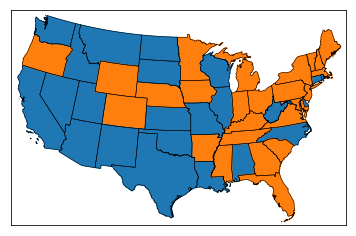

[0, 1, 2, 1, 0, 1, 1, 2, 0, 1, 1, 2, 0, 1, 0, 1, 0, 0, 2, 2, 0, 0, 1, 1, 0, 1, 2, 2, 1, 2, 1, 1, 0, 1, 2, 0, 1, 0, 1, 0, 1, 1, 0, 2, 1, 0, 2, 1, 2]
273


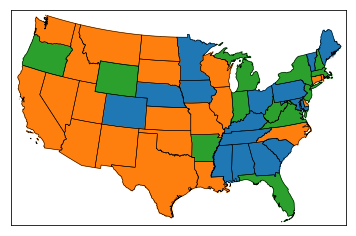

[2, 2, 0, 2, 3, 0, 0, 0, 3, 2, 0, 3, 0, 2, 3, 0, 3, 3, 3, 3, 3, 1, 3, 2, 3, 2, 3, 0, 2, 3, 3, 2, 3, 3, 0, 0, 2, 3, 2, 0, 2, 2, 3, 3, 2, 3, 3, 2, 1]
273


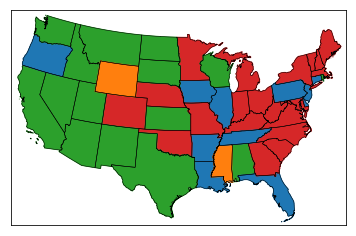

[4, 2, 0, 2, 3, 0, 0, 0, 3, 2, 0, 3, 4, 2, 3, 0, 3, 3, 3, 3, 3, 1, 3, 2, 3, 2, 3, 1, 2, 3, 3, 2, 3, 3, 1, 0, 2, 3, 2, 0, 2, 2, 3, 3, 2, 4, 3, 2, 1]
273


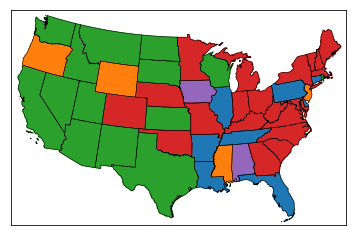

[4, 1, 1, 1, 4, 0, 0, 0, 0, 2, 0, 3, 4, 1, 3, 0, 3, 3, 3, 0, 3, 4, 3, 2, 3, 2, 3, 0, 2, 0, 3, 2, 0, 3, 1, 0, 2, 3, 2, 0, 1, 2, 3, 3, 1, 4, 3, 2, 5]
273


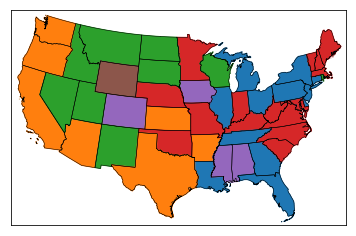

[4, 1, 1, 6, 3, 0, 0, 0, 0, 2, 0, 3, 4, 6, 3, 0, 6, 3, 3, 0, 3, 5, 3, 2, 3, 6, 3, 5, 2, 0, 3, 6, 0, 3, 1, 0, 2, 3, 2, 0, 6, 6, 3, 3, 1, 4, 3, 2, 6]
273


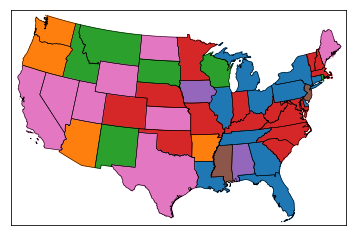

[0, 1, 7, 6, 7, 6, 3, 7, 5, 1, 0, 7, 2, 6, 5, 3, 5, 7, 5, 7, 7, 4, 5, 7, 5, 0, 7, 5, 3, 5, 5, 6, 0, 7, 6, 0, 7, 5, 3, 5, 6, 3, 7, 0, 6, 7, 7, 3, 6]
273


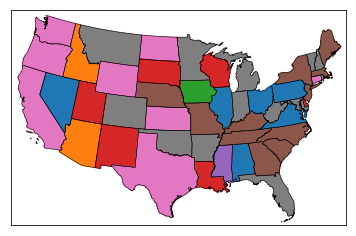

[5, 5, 0, 4, 5, 5, 1, 1, 0, 5, 5, 0, 6, 4, 5, 5, 5, 0, 0, 6, 6, 3, 0, 2, 7, 4, 0, 6, 6, 0, 5, 6, 1, 0, 4, 1, 5, 0, 2, 1, 5, 2, 6, 0, 5, 6, 0, 5, 3]
273


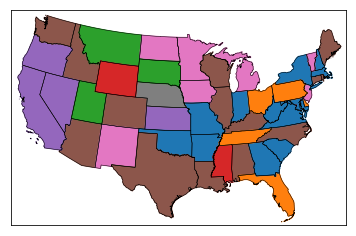

[7, 5, 4, 4, 8, 8, 7, 5, 3, 4, 4, 1, 7, 8, 0, 1, 8, 5, 3, 4, 8, 3, 8, 2, 3, 4, 7, 5, 8, 7, 8, 2, 5, 1, 1, 5, 2, 4, 2, 5, 4, 8, 1, 5, 8, 5, 3, 8, 9]
273


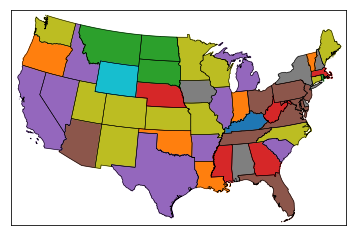

[8, 1, 5, 5, 1, 10, 2, 6, 7, 5, 4, 10, 5, 1, 6, 1, 10, 6, 10, 10, 4, 3, 7, 6, 7, 5, 10, 4, 4, 4, 7, 6, 6, 7, 9, 6, 10, 7, 2, 6, 5, 2, 6, 7, 1, 4, 10, 5, 6]
273


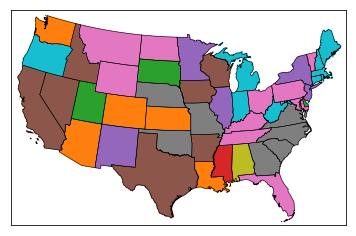

[0, 7, 10, 7, 7, 0, 2, 0, 5, 10, 6, 4, 0, 4, 4, 4, 5, 5, 4, 6, 0, 7, 5, 0, 3, 10, 5, 6, 7, 6, 4, 0, 4, 5, 4, 6, 2, 5, 2, 1, 4, 2, 3, 5, 10, 4, 5, 4, 0]
273


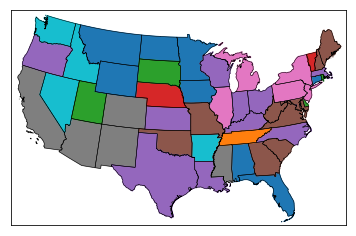

[5, 2, 5, 9, 10, 5, 1, 9, 9, 11, 5, 5, 5, 5, 10, 12, 9, 2, 2, 7, 10, 6, 12, 12, 6, 5, 7, 2, 12, 5, 10, 1, 2, 5, 2, 10, 1, 10, 9, 10, 5, 12, 4, 2, 10, 2, 7, 2, 11]
273


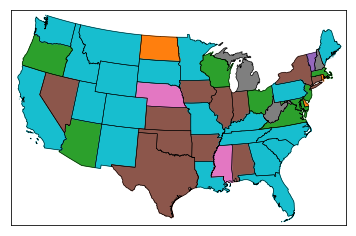

[11, 3, 5, 7, 7, 10, 1, 12, 12, 3, 12, 2, 12, 12, 11, 12, 10, 2, 12, 2, 3, 3, 10, 2, 3, 6, 2, 10, 1, 12, 7, 1, 7, 2, 7, 7, 7, 11, 5, 12, 10, 10, 2, 10, 0, 10, 2, 8, 0]
273


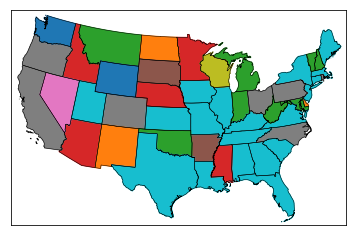

In [29]:
for i in range(0,len(Y1_vecs)):
    state_plotter(pd.DataFrame(Y1_vecs[i]))

In [205]:
list(cols[1])

[0.8901960784313725, 0.46666666666666667, 0.76078431372549016, 1.0]

273


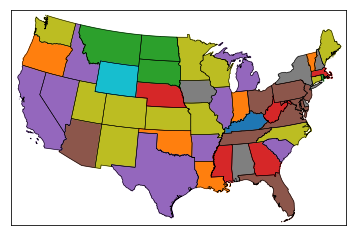

In [293]:
my_tab = pd.crosstab(index=Y,  # Make a crosstab
                              columns="count")
my_tab

In [270]:
len(map.states[2])

15

In [256]:
statenames=[]
for shapedict in m.states_info:
    statename = shapedict['NAME']
    print(statename)
    # skip DC and Puerto Rico.
    if statename not in ['District of Columbia','Puerto Rico']:
        pop = popdensity[statename]
        # calling colormap with value between 0 and 1 returns
        # rgba value.  Invert color range (hot colors are high
        # population), take sqrt root to spread out colors more.
        colors[statename] = cmap(1.-np.sqrt((pop-vmin)/(vmax-vmin)))[:3]
    statenames.append(statename)
len(statenames)

Alaska
Alaska
Alaska
Alaska
Alaska
Alaska
Alaska
Alaska
Alaska
Alaska
Alaska
Alaska
Alaska
Alaska
Alaska
Alaska
Alaska
Alaska
Alaska
Alaska
Alaska
Alaska
Alaska
Alaska
Alaska
Alaska
Alaska
Alaska
Alaska
Alaska
Alaska
Alaska
Alaska
Alaska
Alaska
Alaska
Alaska
Alaska
Alaska
Alaska
Alaska
Alaska
Alaska
Alaska
Alaska
Alaska
Alaska
Alaska
Alaska
Alaska
Alaska
Alaska
Alaska
Alaska
Alaska
Alaska
Alaska
Alaska
Alaska
Alaska
Alaska
Alaska
Alaska
Alaska
Alaska
Alaska
Alaska
Alaska
Alaska
Alaska
Alaska
Alaska
Alaska
Alaska
Alaska
Alaska
Alaska
Alaska
Alaska
Alaska
Alaska
Minnesota
Washington
Washington
Montana
Idaho
North Dakota
Washington
Washington
Washington
Washington
Washington
Washington
Washington
Washington
Michigan
Washington
Michigan
Maine
Wisconsin
Wisconsin
Wisconsin
Wisconsin
Oregon
South Dakota
Michigan
Michigan
Michigan
Wisconsin
New Hampshire
Michigan
Wisconsin
Michigan
Vermont
New York
Wyoming
Maine
Maine
Maine
Maine
Maine
Maine
Maine
Maine
Maine
Maine
Maine
Maine
Maine
Maine
Mai

273

In [257]:
statenames

['Alaska',
 'Alaska',
 'Alaska',
 'Alaska',
 'Alaska',
 'Alaska',
 'Alaska',
 'Alaska',
 'Alaska',
 'Alaska',
 'Alaska',
 'Alaska',
 'Alaska',
 'Alaska',
 'Alaska',
 'Alaska',
 'Alaska',
 'Alaska',
 'Alaska',
 'Alaska',
 'Alaska',
 'Alaska',
 'Alaska',
 'Alaska',
 'Alaska',
 'Alaska',
 'Alaska',
 'Alaska',
 'Alaska',
 'Alaska',
 'Alaska',
 'Alaska',
 'Alaska',
 'Alaska',
 'Alaska',
 'Alaska',
 'Alaska',
 'Alaska',
 'Alaska',
 'Alaska',
 'Alaska',
 'Alaska',
 'Alaska',
 'Alaska',
 'Alaska',
 'Alaska',
 'Alaska',
 'Alaska',
 'Alaska',
 'Alaska',
 'Alaska',
 'Alaska',
 'Alaska',
 'Alaska',
 'Alaska',
 'Alaska',
 'Alaska',
 'Alaska',
 'Alaska',
 'Alaska',
 'Alaska',
 'Alaska',
 'Alaska',
 'Alaska',
 'Alaska',
 'Alaska',
 'Alaska',
 'Alaska',
 'Alaska',
 'Alaska',
 'Alaska',
 'Alaska',
 'Alaska',
 'Alaska',
 'Alaska',
 'Alaska',
 'Alaska',
 'Alaska',
 'Alaska',
 'Alaska',
 'Alaska',
 'Minnesota',
 'Washington',
 'Washington',
 'Montana',
 'Idaho',
 'North Dakota',
 'Washington',
 'Washingto

In [194]:
len(categs)

49

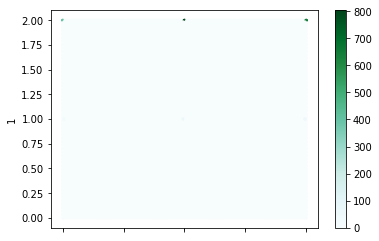

In [50]:
plt.figure();Y1.plot(x=0,y=1,kind="hexbin")

## Build classification battery

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.metrics import f1_score
from sklearn.neural_network import MLPClassifier
import multiprocessing as mp
import time
import os
import random

seed = 7
random.seed(seed)
np.random.seed(seed)
# prepare models
models = []
models.append(("Dummy",DummyClassifier(strategy="most_frequent")))
#models.append(('LR', LogisticRegression(n_jobs=mp.cpu_count()-8,tol=0.1,class_weight="balanced",random_state=seed)))
models.append(('LDA', LinearDiscriminantAnalysis())) 
models.append(('KNN', KNeighborsClassifier(n_jobs=mp.cpu_count()-9,weights="distance")))
models.append(('CART', DecisionTreeClassifier(random_state=seed)))
models.append(('NB', GaussianNB()))
models.append(('RF',RandomForestClassifier(max_depth=10, n_estimators=50, max_features=1,n_jobs=mp.cpu_count()-9,random_state=seed)))
#models.append(('SVM', LinearSVC(class_weight="balanced",random_state=seed)))
models.append(('MLP', MLPClassifier(solver='lbfgs', alpha=1e-5, 
                                   hidden_layer_sizes=(200,200,200,200,200), random_state=seed)))

In [155]:
X_train, X_test, Y_train, Y_test = \
        train_test_split(X, Y, test_size=.15, random_state=42)

In [156]:
np.shape(X_train)
np.shape(Y_train)

(1612327,)

In [157]:
#apply SMOTE oversampling of minority class to correct for imbalances in the data set
import imblearn.over_sampling
smote_sampler = imblearn.over_sampling.SMOTE(ratio="minority")
X_train,Y_train = smote_sampler.fit_sample(X_train,Y_train)

In [158]:
print(np.shape(X_train))
print(np.shape(Y_train))

(2172782, 700)
(2172782,)


In [ ]:
def test_model_battery(name,model,model_name):
    start_time = time.time()
    model.fit(X_train,Y_train)
    Y_pred = model.predict(X_test)
    label = list(set(Y_train))
    #a = f1_score(Y_test,Y_pred,average='weighted',labels=label)
    sc = f1_score(Y_test,Y_pred,average='weighted',labels=label)
    elapsed_time = time.time() - start_time
    
    with open(model_name+".txt", "a") as myfile:
        myfile.write(str(name)+" "+str(sc)+"\n")
    msg = "%s: %f " % (name, sc)
    print(msg)
    #print(f1_score(Y_test,Y_pred,average='weighted',labels=label))
    #print(Y_pred)
    print("calculated in: "+str(elapsed_time)+"s")

In [116]:
#test_model_battery(models[1][0],models[1][1],"test")
#list(set(Y_train))

LDA: 0.204559 
calculated in: 2.437760353088379s


In [ ]:
'_'.join(np.array(models)[:,0])

In [ ]:
from joblib import Parallel, delayed
model_name = "Regional_2m"
scoring = "f1"
try:
    os.remove(model_name+".txt")
except (FileNotFoundError):
    pass


if __name__ == '__main__':
    Parallel(n_jobs=9)(delayed(test_model_battery)(name,model,model_name) for name,model in models)


/home/servan/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Dummy: 0.007855 
calculated in: 0.49235987663269043s
RF: 0.211390 
calculated in: 56.45842170715332s
NB: 0.157266 
calculated in: 206.35569977760315s
CART: 0.256660 
calculated in: 10005.960584402084s


In [ ]:
data = pd.read_csv(model_name+".txt", sep=" ", header=None)
data

## Ignore stuff below

## Build classification model

In [73]:
#http://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html
print(__doc__)


# Code source: Gaël Varoquaux
#              Andreas Müller
# Modified for documentation by Jaques Grobler
# License: BSD 3 clause

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

h = .02  # step size in the mesh

names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

X, y = make_classification(n_features=2, n_redundant=0, n_informative=2,
                           random_state=1, n_clusters_per_class=1)
rng = np.random.RandomState(2)
X += 2 * rng.uniform(size=X.shape)
linearly_separable = (X, y)

datasets = [make_moons(noise=0.3, random_state=0),
            make_circles(noise=0.2, factor=0.5, random_state=1),
            linearly_separable
            ]


assign a single coordinate to rows with location tag "place


In [86]:
linearly_separable

(array([[-0.17749658,  0.93049627],
        [ 1.97742406,  1.76615529],
        [ 1.80002379,  1.7003428 ],
        [-0.77083686,  2.35916348],
        [-0.30800901,  1.59406316],
        [ 0.61472141,  2.43489824],
        [ 1.0909431 ,  2.21663402],
        [-0.83488954,  2.35868875],
        [ 2.47946499,  1.33418967],
        [ 1.19926597,  1.82681392],
        [ 2.18506184,  0.8226875 ],
        [ 1.68423203,  1.0411311 ],
        [ 1.14621135,  2.07048527],
        [ 1.35596945,  0.56802498],
        [ 1.38520748,  1.82607238],
        [ 1.86729217,  1.18692699],
        [ 0.31227376,  2.24605353],
        [-0.08183484,  1.70065511],
        [ 0.90484472,  2.60683016],
        [-0.4358609 ,  2.0151414 ],
        [ 0.81441196,  2.13546784],
        [ 3.10874312,  2.26786504],
        [-0.25574217,  1.71281146],
        [ 1.88663027,  2.72089513],
        [ 2.29503547,  3.89267759],
        [-0.11415626,  0.85593357],
        [ 1.69703537,  3.47717799],
        [ 1.83855775,  0.926

/home/servan/anaconda3/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/home/servan/anaconda3/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/home/servan/anaconda3/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


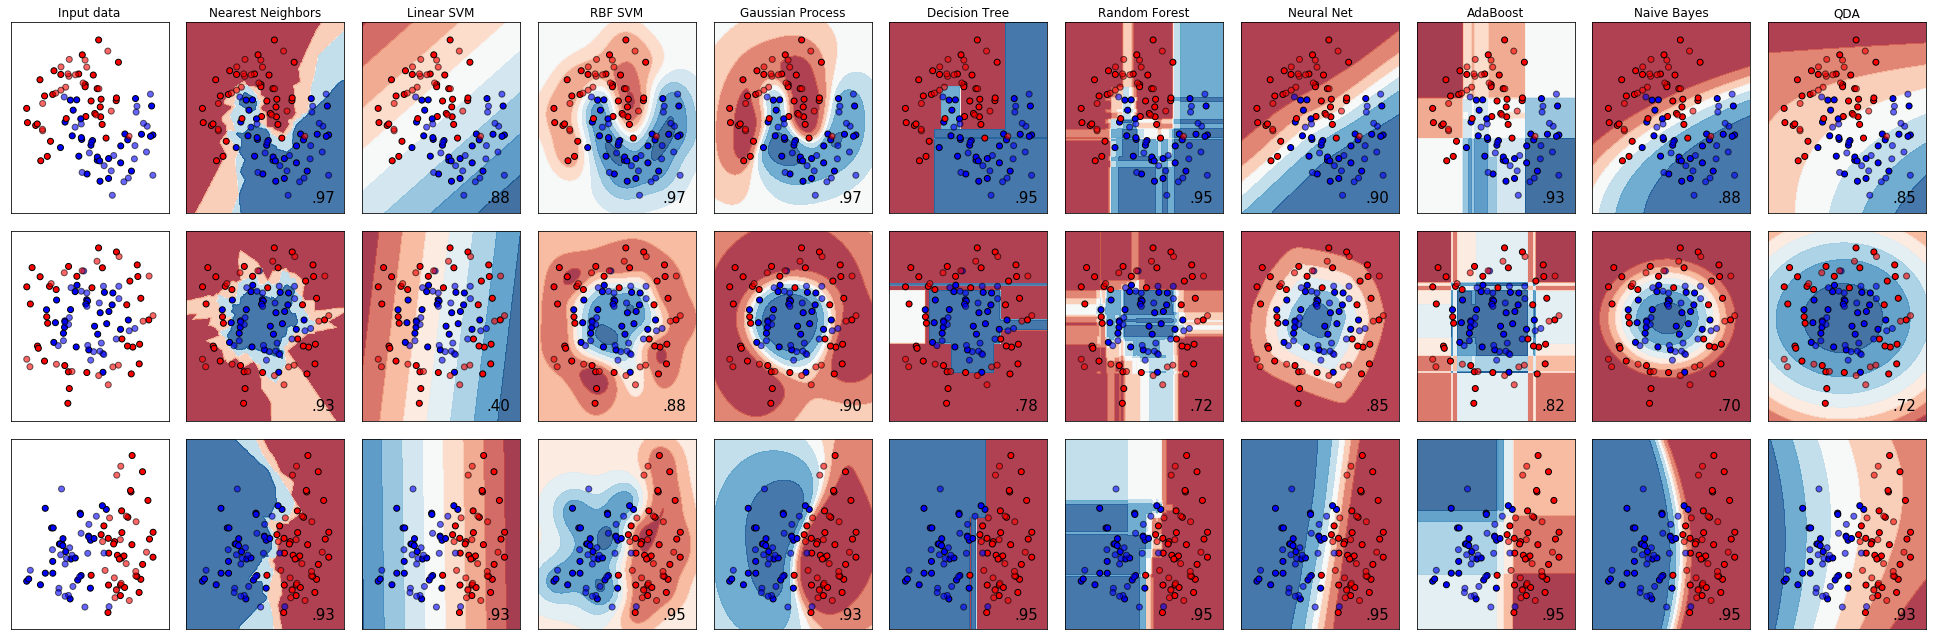

In [85]:
figure = plt.figure(figsize=(27, 9))
i = 1
datasets = list([X,Y])
# iterate over datasets
for ds_cnt, ds in enumerate(datasets):
    # preprocess dataset, split into training and test part
    X, y = ds
    X = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size=.4, random_state=42)

    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # just plot the dataset first
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
    if ds_cnt == 0:
        ax.set_title("Input data")
    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
               edgecolors='k')
    # and testing points
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6,
               edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    i += 1

    # iterate over classifiers
    for name, clf in zip(names, classifiers):
        ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)

        # Plot the decision boundary. For that, we will assign a color to each
        # point in the mesh [x_min, x_max]x[y_min, y_max].
        if hasattr(clf, "decision_function"):
            Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        else:
            Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)

        # Plot also the training points
        ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
                   edgecolors='k')
        # and testing points
        ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright,
                   edgecolors='k', alpha=0.6)

        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_xticks(())
        ax.set_yticks(())
        if ds_cnt == 0:
            ax.set_title(name)
        ax.text(xx.max() - .3, yy.min() + .3, ('%.2f' % score).lstrip('0'),
                size=15, horizontalalignment='right')
        i += 1

plt.tight_layout()
plt.show()

1
LR: 0.110855 (0.055624)
2

/home/servan/anaconda3/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:455: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/home/servan/anaconda3/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:455: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/home/servan/anaconda3/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:455: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/home/servan/anaconda3/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:455: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)

LDA: 0.100735 (0.048121)
3
KNN: 0.065485 (0.026010)
4
CART: 0.056735 (0.013554)
5
NB: 0.006275 (0.001820)
6
SVM: 0.111875 (0.057501)


1
LR: 0.110855 (0.055624)
2

/home/servan/anaconda3/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:455: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/home/servan/anaconda3/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:455: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/home/servan/anaconda3/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:455: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/home/servan/anaconda3/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:455: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)

LDA: 0.100735 (0.048121)
3
KNN: 0.065485 (0.026010)
4
CART: 0.056735 (0.013554)
5
NB: 0.006275 (0.001820)
6


# Not Used

In [19]:
#Tokenize & Count tokens in tweet text
#from https://marcobonzanini.com/2015/03/09/mining-twitter-data-with-python-part-2/
emoticons_str = r"""
    (?:
        [:=;] # Eyes
        [oO\-]? # Nose (optional)
        [D\)\]\(\]/\\OpP] # Mouth
    )"""
 
regex_str = [
    emoticons_str,
    r'<[^>]+>', # HTML tags
    r'(?:@[\w_]+)', # @-mentions
    r"(?:\#+[\w_]+[\w\'_\-]*[\w_]+)", # hash-tags
    r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&amp;+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+', # URLs
 
    r'(?:(?:\d+,?)+(?:\.?\d+)?)', # numbers
    r"(?:[a-z][a-z'\-_]+[a-z])", # words with - and '
    r'(?:[\w_]+)', # other words
    r'(?:\S)' # anything else
]
tokens_re = re.compile(r'('+'|'.join(regex_str)+')', re.VERBOSE | re.IGNORECASE)
emoticon_re = re.compile(r'^'+emoticons_str+'$', re.VERBOSE | re.IGNORECASE)

def tokenize(s):
    return tokens_re.findall(s)
 
def preprocess(s, lowercase=False,stopwords_rm=False,**kwargs):
    tokens = tokenize(s)
    if lowercase:
        tokens = [token if emoticon_re.search(token) else token.lower() for token in tokens]
    if stopwords_rm:
        tokens = [token for token in tokens if token not in kwargs["stop_words"]]
    return tokens

In [20]:
dtw_tokens= dd.from_pandas(tw["text"], npartitions=mp.cpu_count()-1)
dtw_tokens = dtw_tokens.map(preprocess,True,meta=dtw_tokens)
#tw["tokens"] = tw["text"].apply(preprocess,lowercase=True)
tw["tokens"] = dtw_tokens.compute()

/home/servan/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [21]:
#Count occurrence of each word
counts = Counter(itertools.chain.from_iterable(tw["tokens"]))

In [22]:
counts

Counter({'#addmeonsnapchat': 1,
         'https://t.co/URaNlqaA1O': 1,
         '@NBAMemes': 5,
         'Accidente': 1,
         'https://t.co/CFpq2ypVNV': 1,
         '@M_J_P_C_': 2,
         '@suttygal': 5,
         '@vaderband': 1,
         '@jihyewisdom1': 3,
         'http://t.co/MZcdZ3CkP1': 1,
         'CPort': 1,
         'VALEZQUEZ': 1,
         'https://t.co/03orOiETXp': 1,
         'https://t.co/FznFAYLxi1': 1,
         'https://t.co/pcvrLAlWiV': 1,
         '@FlyGuyJee': 1,
         '@Youlikeunique': 1,
         '#smartMONEY': 1,
         '@aysiarias': 1,
         '30.217': 1,
         '@dhoodenpyle2': 1,
         '@scotch_trooper': 2,
         '#SUGARLOAFKEY': 1,
         'https://t.co/iiks7ESCYK': 1,
         'tambieeeen': 1,
         '@AlyssaLynette1': 1,
         '@MeghanMess': 1,
         '#Lumira': 1,
         '@tralenlove': 5,
         'https://t.co/B8LQTy4Huc': 1,
         'Squaw': 14,
         '@matia_nargi': 2,
         'https://t.co/3LPAUDWzyo': 1,
         'Cal

In [23]:
#remove punctuation and stopwords
punctuation = list(string.punctuation)
stop = stopwords.words('english') + punctuation + ['rt', 'via']
#tw["tokens_stop"] = tw["text"].apply(preprocess,lowercase=True,
                              #stopwords_rm = True, stop_words=stop)

dtw_tokens= dd.from_pandas(tw["text"], npartitions=mp.cpu_count()-1)
dtw_tokens = dtw_tokens.map(preprocess,(True,True, stop), meta=dtw_tokens)
tw["tokens_stop"] = dtw_tokens.compute()

/home/servan/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [24]:
tw

,id,time,text,coord,loc_tag,tokens,tokens_stop
0,776376269281849344,2016-09-15 11:05:01,@julietchiapell0 thanks Juliet!!,"[-77.438513, 38.841163]",place,"[@julietchiapell0, thanks, Juliet, !, !]","[@julietchiapell0, thanks, Juliet, !, !]"
1,776376270175232000,2016-09-15 11:05:01,last night was pretty rad and now i'm a cute b...,"[-82.7184075, 27.8172385]",place,"[last, night, was, pretty, rad, and, now, i'm,...","[last, night, was, pretty, rad, and, now, i'm,..."
2,776376270338793473,2016-09-15 11:05:01,@badgalbree_ kys you better not go to no just...,"[-76.5136315, 38.2799235]",place,"[@badgalbree_, kys, you, better, not, go, to, ...","[@badgalbree_, kys, you, better, not, go, to, ..."
3,776376270716215296,2016-09-15 11:05:01,Breaking bad is so bad ass I've been watching ...,"[-97.1356375, 32.70185]",place,"[Breaking, bad, is, so, bad, ass, I've, been, ...","[Breaking, bad, is, so, bad, ass, I've, been, ..."
4,776376270103904256,2016-09-15 11:05:01,Hoy es 15 de septiembre día de la Independenci...,"[-73.5842655, 40.648987]",place,"[Hoy, es, 15, de, septiembre, día, de, la, Ind...","[Hoy, es, 15, de, septiembre, día, de, la, Ind..."
5,776376271097827328,2016-09-15 11:05:02,I'm in one spot all day dm me to get some gear...,"[-77.0143985, 38.898603]",place,"[I'm, in, one, spot, all, day, dm, me, to, get...","[I'm, in, one, spot, all, day, dm, me, to, get..."
6,776376271882358785,2016-09-15 11:05:02,@gktrocks Good Morning Griff! I hope all Rocks...,"[-73.9685415, 40.780709]",place,"[@gktrocks, Good, Morning, Griff, !, I, hope, ...","[@gktrocks, Good, Morning, Griff, !, I, hope, ..."
7,776376271718744064,2016-09-15 11:05:02,@yoitskylah @Kennedy626 @_rileysarah @AlphaAce...,"[-83.1738665, 32.6782075]",place,"[@yoitskylah, @Kennedy626, @_rileysarah, @Alph...","[@yoitskylah, @Kennedy626, @_rileysarah, @Alph..."
8,776376271861379072,2016-09-15 11:05:02,Truly Blessed to see 17!!,"[-72.757385, 41.500753]",place,"[Truly, Blessed, to, see, 17, !, !]","[Truly, Blessed, to, see, 17, !, !]"
9,776376272398188544,2016-09-15 11:05:02,Looking like shit for picture day!,"[-81.49715, 41.3135005]",place,"[Looking, like, shit, for, picture, day, !]","[Looking, like, shit, for, picture, day, !]"


In [38]:
#create bigrams
#tw["bigrams"] = tw["tokens_stop"].apply(bigrams)
tw["bigrams"] = dd.from_pandas(tw["tokens_stop"],npartitions=mp.cpu_count()-1).map(bigrams).compute()

/home/servan/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [39]:
tw

,id,time,text,coord,loc_tag,tokens,tokens_stop,bigrams
0,776376269281849344,2016-09-15 11:05:01,@julietchiapell0 thanks Juliet!!,"[-77.438513, 38.841163]",place,"[@julietchiapell0, thanks, Juliet, !, !]","[@julietchiapell0, thanks, Juliet, !, !]",<generator object bigrams at 0x7f5c845b9af0>
1,776376290500894720,2016-09-15 11:05:06,I can't choose a side. Man on The Moon make me...,"[-76.9924405, 38.752715]",place,"[I, can't, choose, a, side, ., Man, on, The, M...","[I, can't, choose, a, side, ., Man, on, The, M...",<generator object bigrams at 0x7f5c845b9c50>
2,776376318971809792,2016-09-15 11:05:13,"@Tavi59 saw him in Denver last year, Taj Mahal...","[-105.0639425, 40.5641905]",place,"[@Tavi59, saw, him, in, Denver, last, year, ,,...","[@Tavi59, saw, him, in, Denver, last, year, ,,...",<generator object bigrams at 0x7f5c845b9a40>
3,776376343990763520,2016-09-15 11:05:19,damn never seen a backflip on a dick https://t...,"[-75.117998, 40.0048655]",place,"[damn, never, seen, a, backflip, on, a, dick, ...","[damn, never, seen, a, backflip, on, a, dick, ...",<generator object bigrams at 0x7f5c845b97d8>
4,776376363460730880,2016-09-15 11:05:24,They time when the @Starbucks baristas not on...,"[-76.303738, 40.15251]",place,"[They, time, when, the, @Starbucks, baristas, ...","[They, time, when, the, @Starbucks, baristas, ...",<generator object bigrams at 0x7f5c845b9938>
5,776376386017718272,2016-09-15 11:05:29,@ConnValleyLax @ZimaGear nice work - as always...,"[-77.712567, 43.1626595]",place,"[@ConnValleyLax, @ZimaGear, nice, work, -, as,...","[@ConnValleyLax, @ZimaGear, nice, work, -, as,...",<generator object bigrams at 0x7f5c845b9728>
6,776376405907079169,2016-09-15 11:05:34,You stole my avi @MahoneyKelli,"[-89.2665075, 39.7393005]",place,"[You, stole, my, avi, @MahoneyKelli]","[You, stole, my, avi, @MahoneyKelli]",<generator object bigrams at 0x7f5c845b9678>
7,776376426245320704,2016-09-15 11:05:39,My pillow smells like @wild_hvnt95 and it's great,"[-83.0677285, 39.849473]",place,"[My, pillow, smells, like, @wild_hvnt95, and, ...","[My, pillow, smells, like, @wild_hvnt95, and, ...",<generator object bigrams at 0x7f5c845b9570>
8,776376442615504896,2016-09-15 11:05:42,already hit the snooze button 3 times this mor...,"[-83.804475, 27.698682]",place,"[already, hit, the, snooze, button, 3, times, ...","[already, hit, the, snooze, button, 3, times, ...",<generator object bigrams at 0x7f5c845b9360>
9,776376455781453833,2016-09-15 11:05:46,"If you're looking for work in #Orlando, FL, ch...","[-81.3792365, 28.5383355]",coordinates,"[If, you're, looking, for, work, in, #Orlando,...","[If, you're, looking, for, work, in, #Orlando,...",<generator object bigrams at 0x7f5c845b9410>


In [35]:
#tw = tw[[i is not None for i in tw["coord"]]]

In [32]:
import os
import time
import sys
import re
from subprocess import call
import numpy as np
from nltk import TweetTokenizer
from nltk.tokenize import StanfordTokenizer

In [33]:
import os
FASTTEXT_EXEC_PATH = os.path.abspath("~/sent2vec/fasttext")

BASE_SNLP_PATH = "~/sent2vec/"
SNLP_TAGGER_JAR = os.path.join(BASE_SNLP_PATH, "stanford-postagger.jar")

#MODEL_WIKI_UNIGRAMS = os.path.abspath("./sent2vec_wiki_unigrams")
#MODEL_WIKI_BIGRAMS = os.path.abspath("./sent2vec_wiki_bigrams")
#MODEL_TORONTOBOOKS_UNIGRAMS = os.path.abspath("./sent2vec_wiki_unigrams")
#MODEL_TORONTOBOOKS_BIGRAMS = os.path.abspath("./sent2vec_wiki_bigrams")
#MODEL_TWITTER_UNIGRAMS = os.path.abspath('./sent2vec_twitter_unigrams')
MODEL_TWITTER_BIGRAMS = os.path.abspath('/tmp/sent2vec_twitter_bigrams')

In [34]:
import time
def tokenize(tknzr, sentence, to_lower=True):
    """Arguments:
        - tknzr: a tokenizer implementing the NLTK tokenizer interface
        - sentence: a string to be tokenized
        - to_lower: lowercasing or not
    """
    sentence = sentence.strip()
    sentence = ' '.join([format_token(x) for x in tknzr.tokenize(sentence)])
    if to_lower:
        sentence = sentence.lower()
    sentence = re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))','<url>',sentence) #replace urls by <url>
    sentence = re.sub('(\@[^\s]+)','<user>',sentence) #replace @user268 by <user>
    filter(lambda word: ' ' not in word, sentence)
    return sentence

def format_token(token):
    """"""
    if token == '-LRB-':
        token = '('
    elif token == '-RRB-':
        token = ')'
    elif token == '-RSB-':
        token = ']'
    elif token == '-LSB-':
        token = '['
    elif token == '-LCB-':
        token = '{'
    elif token == '-RCB-':
        token = '}'
    return token
 
def tokenize_sentences(tknzr, sentences, to_lower=True):
    """Arguments:
        - tknzr: a tokenizer implementing the NLTK tokenizer interface
        - sentences: a list of sentences
        - to_lower: lowercasing or not
    """
    return [tokenize(tknzr, s, to_lower) for s in sentences]

def get_embeddings_for_preprocessed_sentences(sentences, model_path, fasttext_exec_path):
    """Arguments:
        - sentences: a list of preprocessed sentences
        - model_path: a path to the sent2vec .bin model
        - fasttext_exec_path: a path to the fasttext executable
    """
    timestamp = str(time.time())
    test_path = os.path.abspath('./'+timestamp+'_fasttext.test.txt')
    embeddings_path = os.path.abspath('./'+timestamp+'_fasttext.embeddings.txt')
    dump_text_to_disk(test_path, sentences)
    call(fasttext_exec_path+
          ' print-sentence-vectors '+
          model_path + ' < '+
          test_path + ' > ' +
          embeddings_path, shell=True)
    embeddings = read_embeddings(embeddings_path)
    os.remove(test_path)
    os.remove(embeddings_path)
    assert(len(sentences) == len(embeddings))
    return np.array(embeddings)

def read_embeddings(embeddings_path):
    """Arguments:
        - embeddings_path: path to the embeddings
    """
    with open(embeddings_path, 'r') as in_stream:
        embeddings = []
        for line in in_stream:
            line = '['+line.replace(' ',',')+']'
            embeddings.append(eval(line))
        return embeddings
    return []

def dump_text_to_disk(file_path, X, Y=None):
    """Arguments:
        - file_path: where to dump the data
        - X: list of sentences to dump
        - Y: labels, if any
    """
    with open(file_path, 'w') as out_stream:
        if Y is not None:
            for x, y in zip(X, Y):
                out_stream.write('__label__'+str(y)+' '+x+' \n')
        else:
            for x in X:
                out_stream.write(x+' \n')

def get_sentence_embeddings(sentences, ngram='bigrams', model='concat_wiki_twitter'):
    """ Returns a numpy matrix of embeddings for one of the published models. It
    handles tokenization and can be given raw sentences.
    Arguments:
        - ngram: 'unigrams' or 'bigrams'
        - model: 'wiki', 'twitter', or 'concat_wiki_twitter'
        - sentences: a list of raw sentences ['Once upon a time', 'This is another sentence.', ...]
    """
    wiki_embeddings = None
    twitter_embbedings = None
    tokenized_sentences_NLTK_tweets = None
    tokenized_sentences_SNLP = None
    if model == "wiki" or model == 'concat_wiki_twitter':
        tknzr = StanfordTokenizer(SNLP_TAGGER_JAR, encoding='utf-8')
        s = ' <delimiter> '.join(sentences) #just a trick to make things faster
        tokenized_sentences_SNLP = tokenize_sentences(tknzr, [s])
        tokenized_sentences_SNLP = tokenized_sentences_SNLP[0].split(' <delimiter> ')
        assert(len(tokenized_sentences_SNLP) == len(sentences))
        if ngram == 'unigrams':
            wiki_embeddings = get_embeddings_for_preprocessed_sentences(tokenized_sentences_SNLP, \
                                     MODEL_WIKI_UNIGRAMS, FASTTEXT_EXEC_PATH)
        else:
            wiki_embeddings = get_embeddings_for_preprocessed_sentences(tokenized_sentences_SNLP, \
                                     MODEL_WIKI_BIGRAMS, FASTTEXT_EXEC_PATH)
    if model == "twitter" or model == 'concat_wiki_twitter':
        tknzr = TweetTokenizer()
        tokenized_sentences_NLTK_tweets = tokenize_sentences(tknzr, sentences)
        if ngram == 'unigrams':
            twitter_embbedings = get_embeddings_for_preprocessed_sentences(tokenized_sentences_NLTK_tweets, \
                                     MODEL_TWITTER_UNIGRAMS, FASTTEXT_EXEC_PATH)
        else:
            twitter_embbedings = get_embeddings_for_preprocessed_sentences(tokenized_sentences_NLTK_tweets, \
                                     MODEL_TWITTER_BIGRAMS, FASTTEXT_EXEC_PATH)
    if model == "twitter":
        return twitter_embbedings
    elif model == "wiki":
        return wiki_embeddings
    elif model == "concat_wiki_twitter":
        return np.concatenate((wiki_embeddings, twitter_embbedings), axis=1)
    sys.exit(-1)

In [35]:
get_sentence_embeddings(tw["text"],ngram="bigrams",model="twitter")

AssertionError: 

In [ ]:
read.

In [13]:
tw_sub = tw.loc[:,("id","tokenised")]
tw_sub["tokenised"]

1      last night was pretty rad and now i'm a cute b...
2      <user> kys you better not go to no justin brib...
3      breaking bad is so bad ass i've been watching ...
4      hoy es 15 de septiembre día de la independenci...
5      i'm in one spot all day dm me to get some gear...
6      <user> good morning griff ! i hope all rocks w...
7                     <user> <user> <user> <user> me too
8                            truly blessed to see 17 ! !
9                    looking like shit for picture day !
10                         these hoes ain't your friends
11     8 am classes thursday and mandatory gym time f...
12                                           feels <url>
13     slow hand clap for <user> at <user> this am fo...
14                               some uselees bump <url>
15     <url> is in a spider hole recently vacuumed ye...
16     <user> é relacionamento abusivo quando a pesso...
17                 definetly just heard a gun shooting .
18     <user> <user> did ya'll 

In [16]:
use_cols = ["tokenised"]
filename = "tw_sub_small.txt"
with open(filename,'w') as outfile:
    tw_sub.to_string(outfile,columns=use_cols)

# 2. Build model

## 2.1 Naive Bayes

In [46]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()


In [40]:
from sklearn.datasets import fetch_20newsgroups
categories = ['alt.atheism', 'soc.religion.christian', 'comp.graphics', 'sci.med']

twenty_train = fetch_20newsgroups(subset='train',categories=categories, shuffle=True, random_state=42)

In [42]:
twenty_train.target_names

['alt.atheism', 'comp.graphics', 'sci.med', 'soc.religion.christian']

In [63]:
len(twenty_train.data)
tw <- tw[::50]

TypeError: bad operand type for unary -: 'Timestamp'

In [47]:
X_train_counts = count_vect.fit_transform(tw["text"])

In [62]:
X_train_counts.shape

<37621x57514 sparse matrix of type '<class 'numpy.int64'>'
	with 338646 stored elements in Compressed Sparse Row format>

In [51]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape

(37621, 57514)

In [52]:
tf_transformer = TfidfTransformer(use_idf=False).fit(X_train_counts)
X_train_tf = tf_transformer.transform(X_train_counts)
X_train_tf.shape

(37621, 57514)

from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB().fit(X_train_tfidf, tw["text"])

#api
#fasttext > under https://github.com/facebookresearch/fastText

use language model pre-trained for twitter >
tokenisation first needed >
nltk-tweet tokenizer 

https://github.com/epfml/sent2vec

Model bin can be found on server under tmp/sent2vec_twitter_bigrams.bin

Wahrscheinlichkeiten aus Vektoren 
- Input: 700dim Vektor (aus Tweet-Inhalt); Target-State (as integers)
- Output: Probabilities

Use SVMs
linear classifier?
linear SVMs
multinomiale Logistische Regression

Rankings instead of accuracy > use rankings

character-based approach
sent2vec > 

tmux-tab

binary > tmp/sent2vec_twitter_bigrams.bin

sudo apt-get install tmux

Detach: ctrl-B > d
tmux a -t 0
tmux a
tmux --help

tmux kill session -t 0

5 million tweet, not more 

use word vectors as input 
sent2vec > example in the repo how to tokenize repo
fasttext > 
take out URLs & mentions > replace with URL tags
not use tweets with less than 3 words

classifier comparison
don't use grid search

problems when using sent2vec > only for English tweets usable > losing a lot of information
http://localhost:8888/?token=4ba9b1794baf2b32dc6ca517d7ac8dc323a3bbbc3dc00919